In [122]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT

sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
tar = ut.load_target()
PANEL_SCORE = True

## increasing values

In [145]:
series = 'IV'
px, px_ca, px_us = ut.load_series(series)

int: 6.18220627203e-16	coef: 0.543239747314


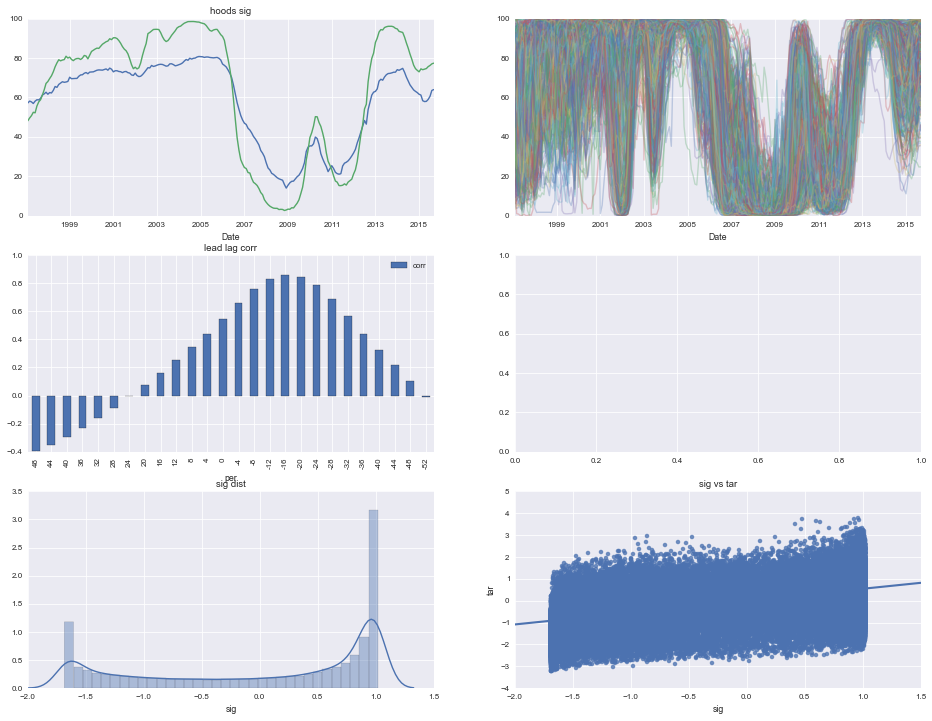

In [146]:
ut.explore_series(px, px_ca, px_us, tar)

## decreasing values

In [31]:
series = 'DV'
px, px_ca, px_us = ut.load_series(series)

int: -9.72514953918e-15	coef: -0.539402120121


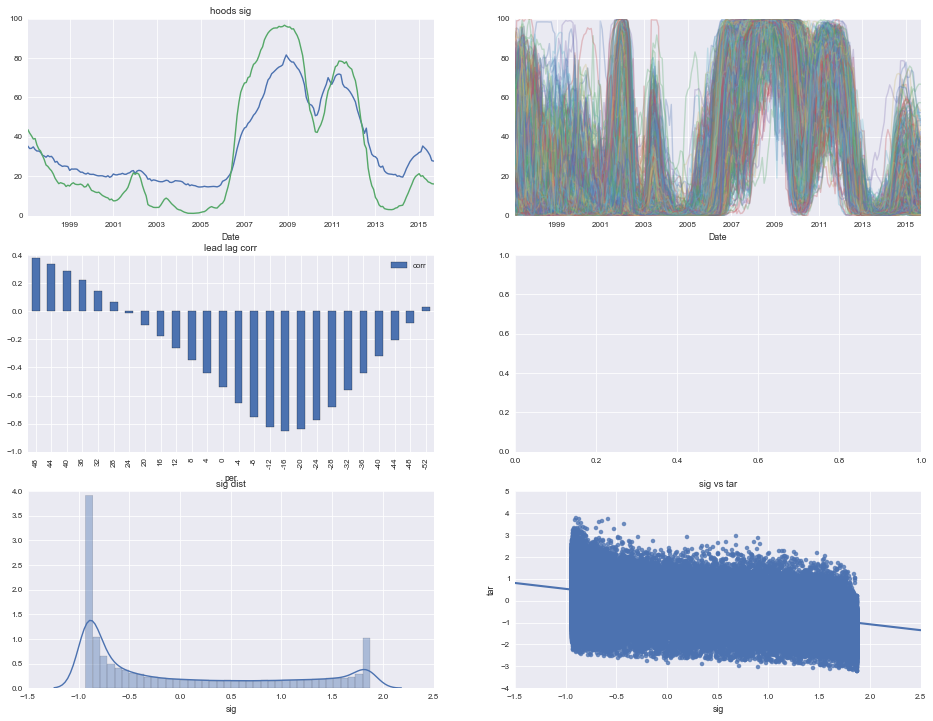

In [32]:
ut.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [33]:
series = 'SLPR'
px, px_ca, px_us = ut.load_series(series)

In [34]:
px

,00003,00004,00007,00014,00021,00025,00032,00034,00035,00037,...,01028,01145,01213,01535,01987,02046,02637,04463,04531,05903
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,0.9954,0.99,0.9937,0.9801,0.9857,0.9987,0.9783,0.9757,0.9872,1.0667,...,0.9734,0.9812,1,0.9747,0.9699,0.9608,0.993141,1.0821,0.9697,0.9956


## turnover in housing market in past year

In [35]:
series = 'SPY'
px, px_ca, px_us = ut.load_series(series)

int: -4.63035810897e-15	coef: 0.12150467813


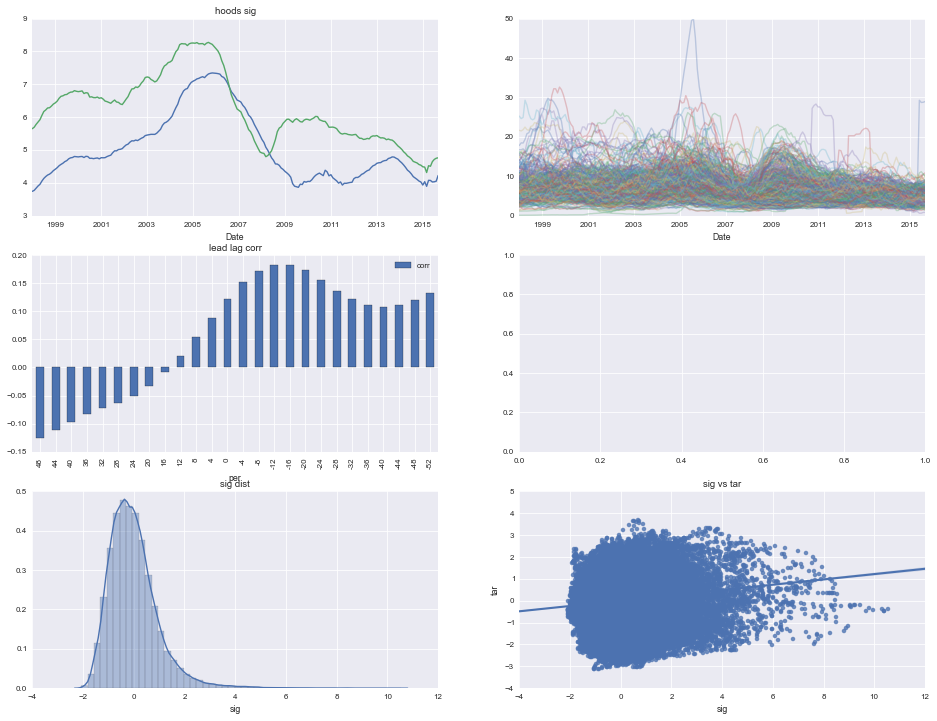

In [36]:
ut.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [77]:
series = 'SFG'
px, px_ca, px_us = ut.load_series(series)

In [78]:
px, px_ca, px_us = ut.capped_change(px, px_ca, px_us)
SFG_c = px

int: 4.45931763155e-15	coef: 0.158829595428


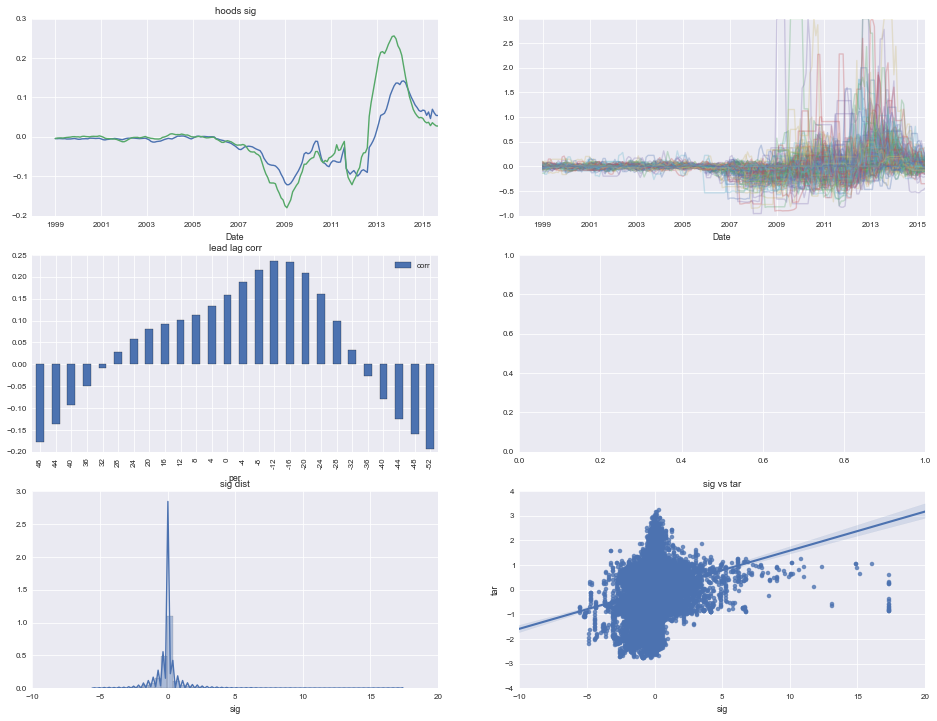

In [39]:
ut.explore_series(px, px_ca, px_us, tar)

# price per square foot

In [79]:
series = 'MVSF'
px, px_ca, px_us = ut.load_series(series)

In [80]:
px, px_ca, px_us = ut.capped_change(px, px_ca, px_us)
MVSF_c = px

int: -2.85943207518e-14	coef: 0.488553051962


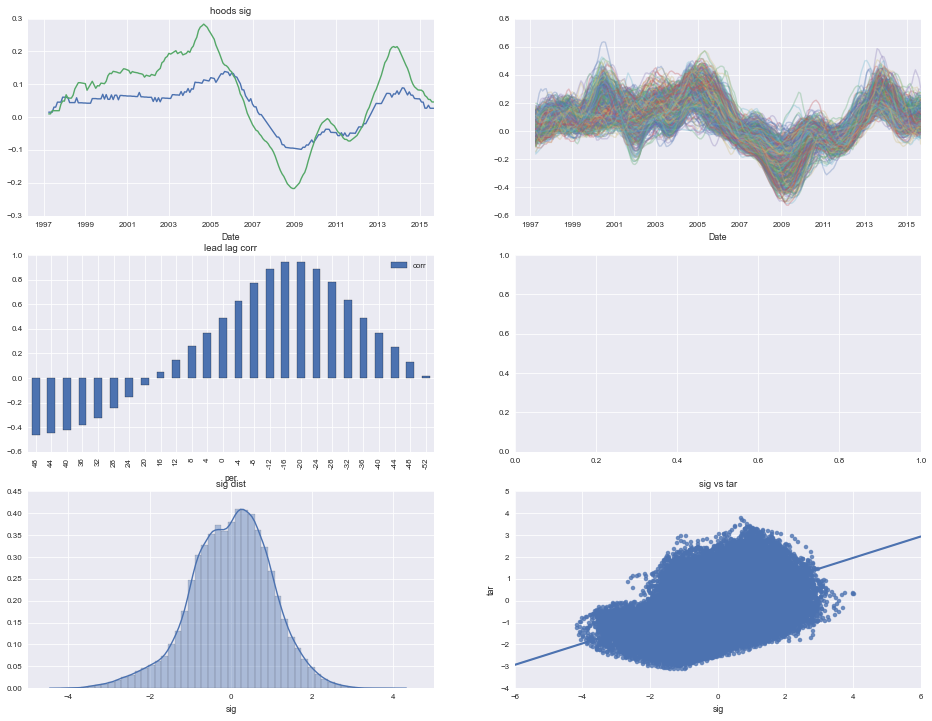

In [67]:
ut.explore_series(px, px_ca, px_us, tar)

## build model

In [286]:
features = {}
for i in ('IV', 'DV', 'SPY'):
    features[i] = ut.load_quandl_data('hoods', i)
features['tar'] = tar
features['SFG'] = SFG_c
features['MVSF'] = MVSF_c
df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
#df = ut.ts_score(df, panel=True)

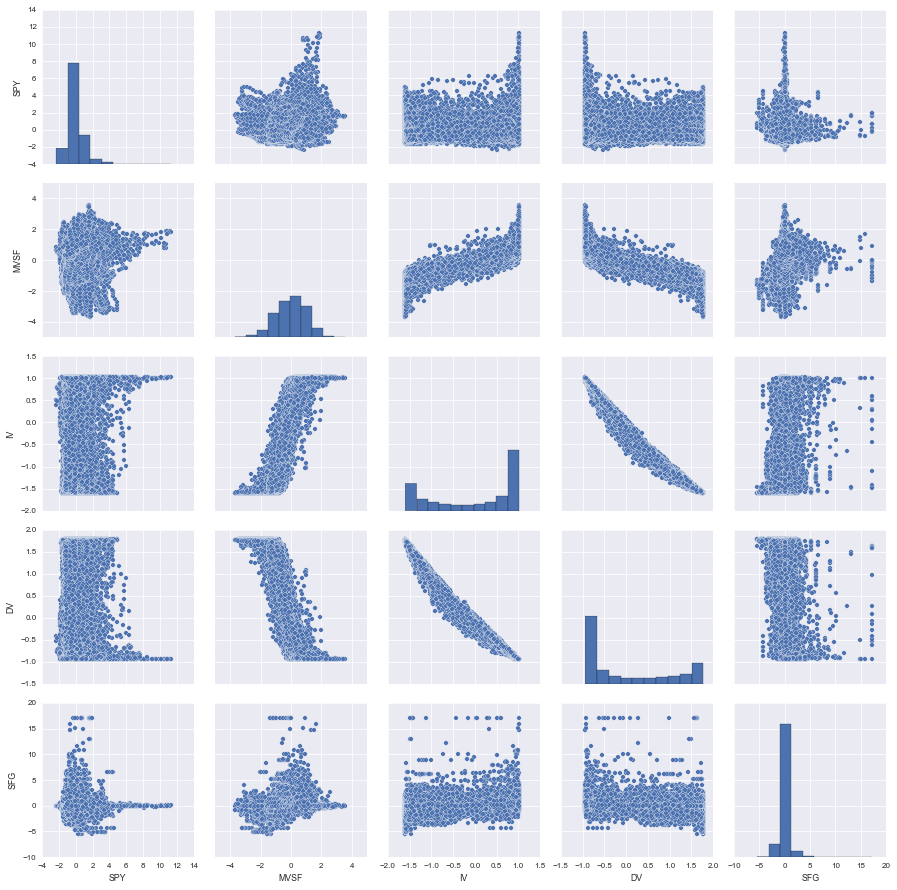

In [82]:
sns.pairplot(df[[c for c in df.columns if c != 'tar']])

sharpe ratios:
0.2    1.356827
0.4    1.888344
0.6    2.242841
0.8    2.340233
1.0    2.354501
mkt    1.837193
dtype: float64

r2: 0.312272293394	int: 4.61868493328e-15	coef: [-0.03506298  0.14315182  0.20153962 -0.17501876  0.02846209]	alpha: 10000


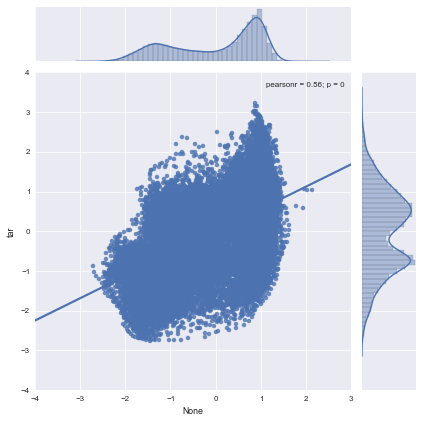

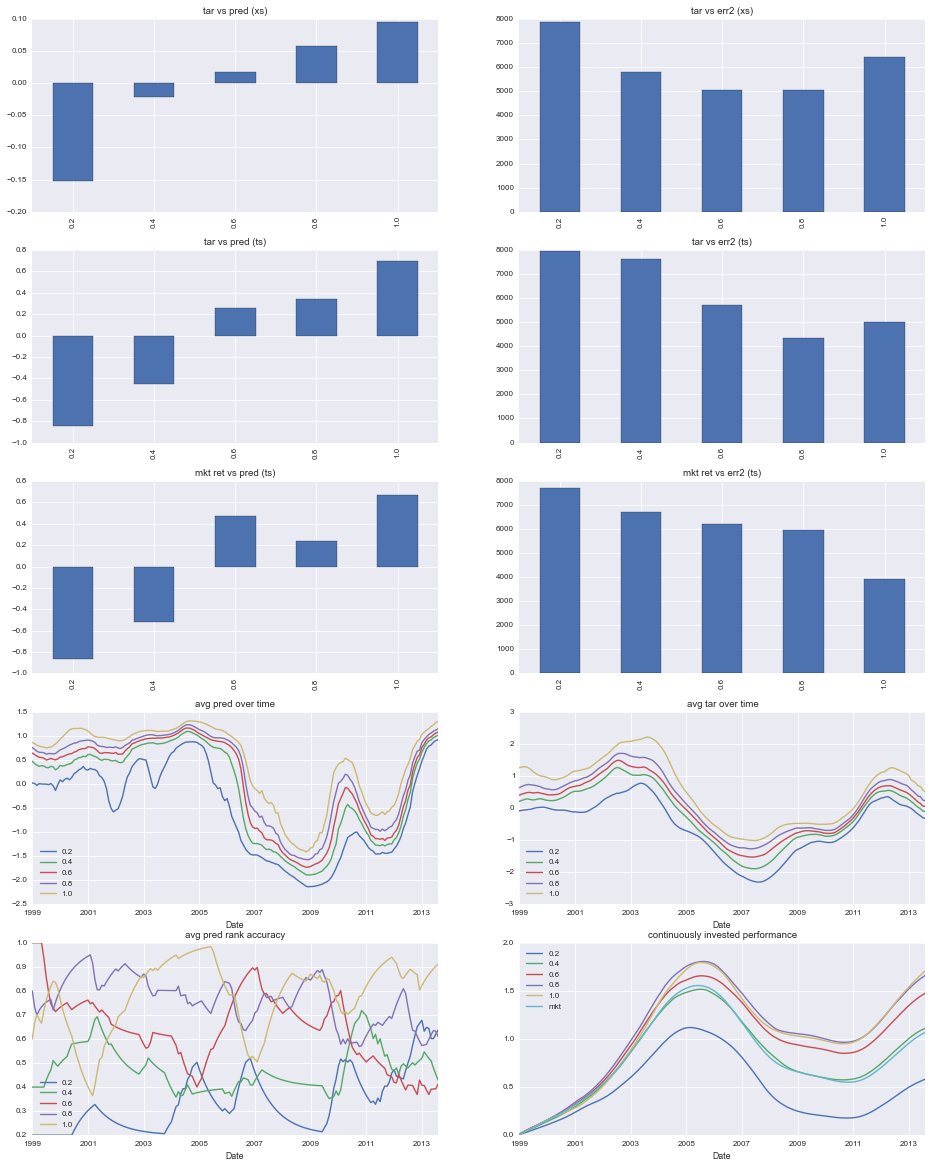

In [281]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    1.387671
0.4    1.897688
0.6    2.253201
0.8    2.342865
1.0    2.327813
mkt    1.837193
dtype: float64

r2: 0.318585139984	int: 4.06054434087e-15	coef: [-0.04909166  0.08813209  0.47827617 -0.          0.01590126]	alpha: 0.01


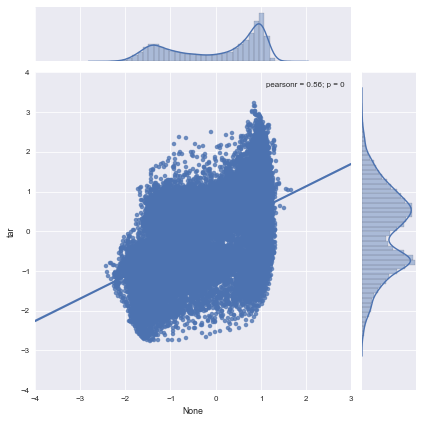

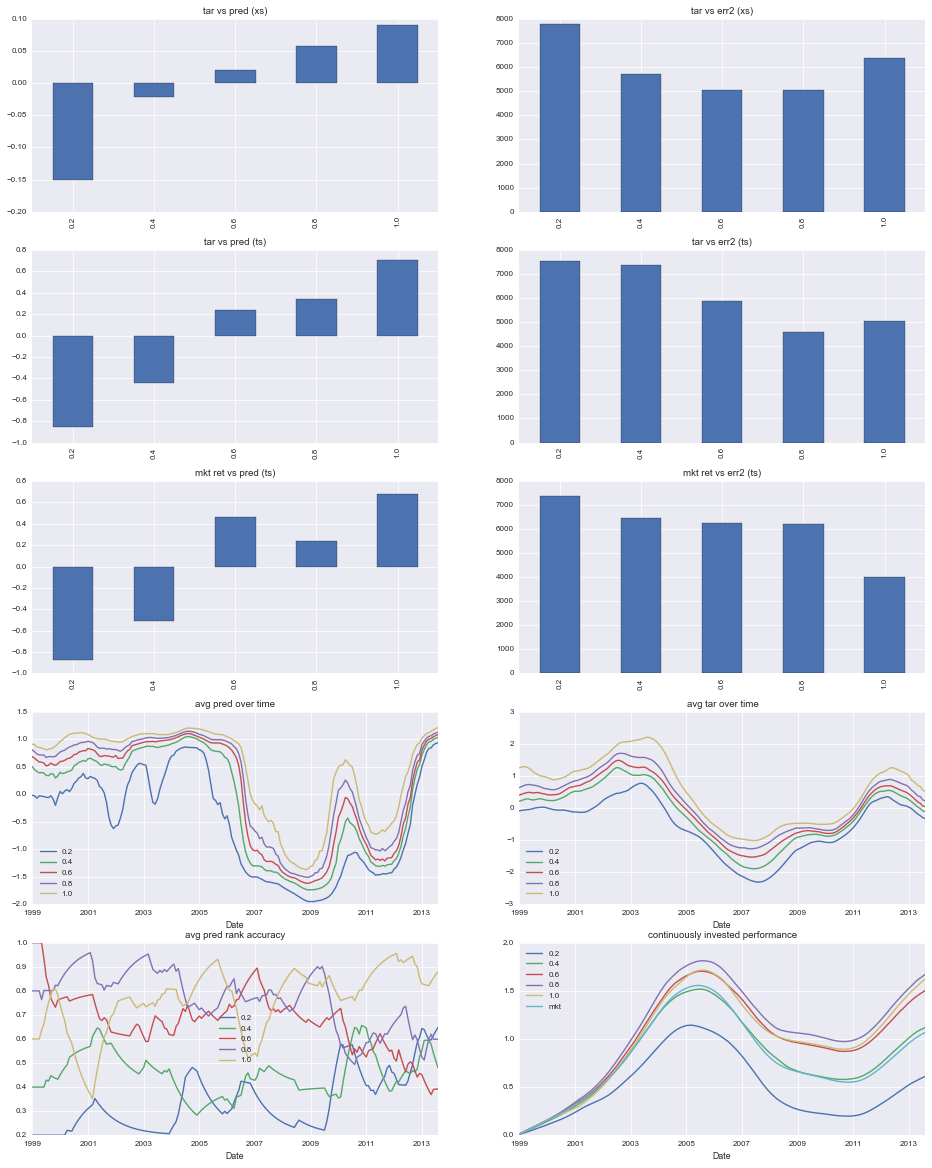

In [282]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score = ut.build_model(clf, df)
score = clf.score(df[[c for c in df.columns if c != 'tar']], df['tar'])
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    1.589879
0.4    1.731405
0.6    0.708315
0.8    0.356637
1.0   -0.364202
mkt    1.837193
dtype: float64

r2: 0.269127723599


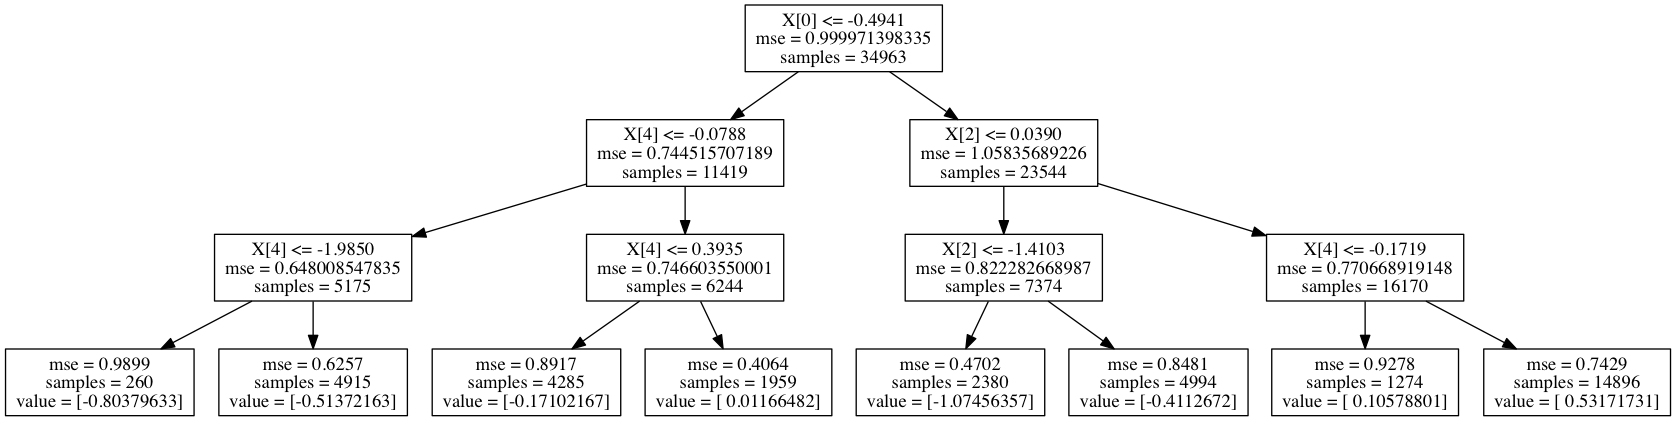

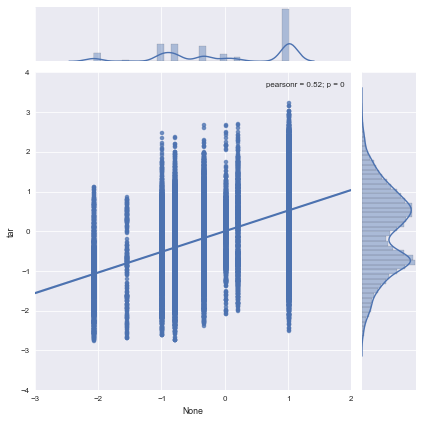

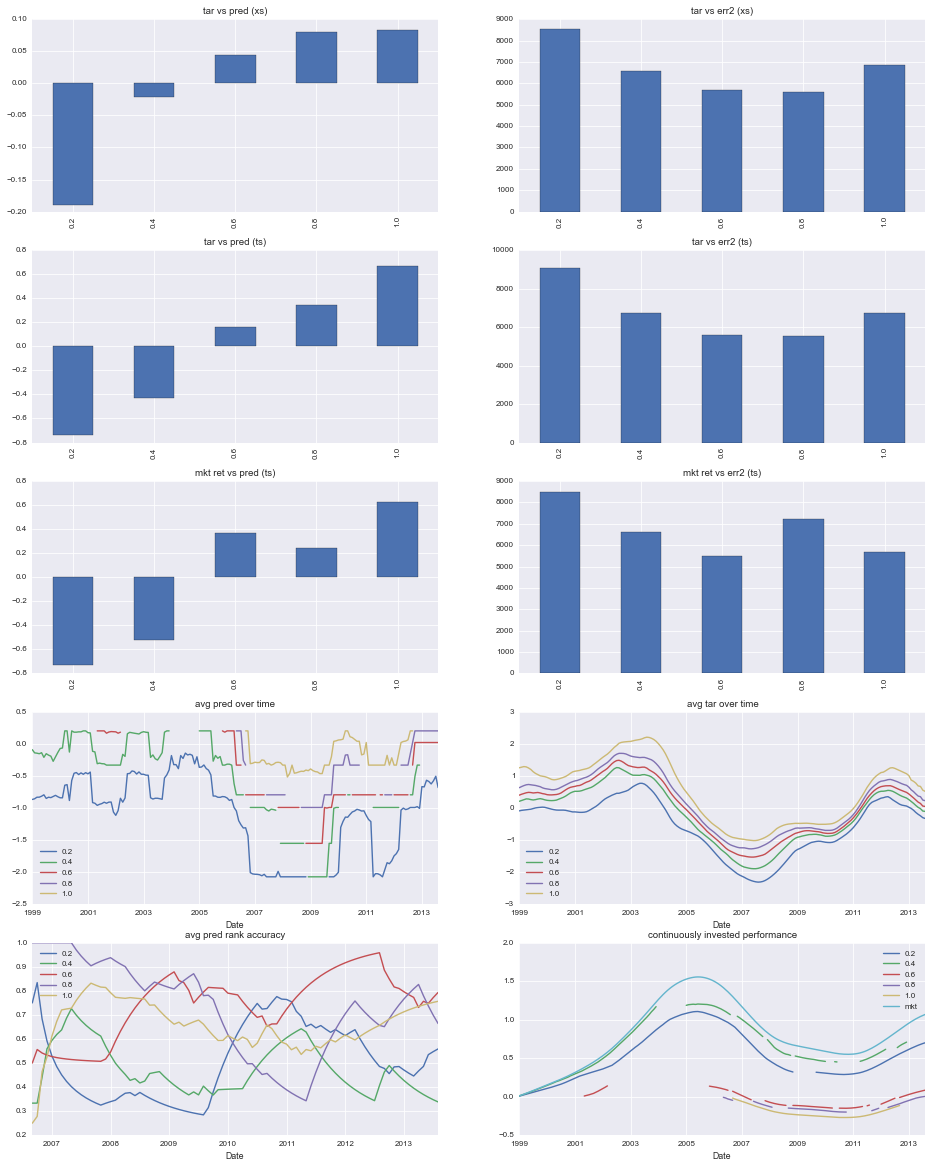

In [283]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))
ut.tree_vis(clf.best_estimator_)

sharpe ratios:
0.2    1.394532
0.4    2.021644
0.6    2.243537
0.8    2.196231
1.0    1.967305
mkt    1.837193
dtype: float64

r2: 0.344936902162


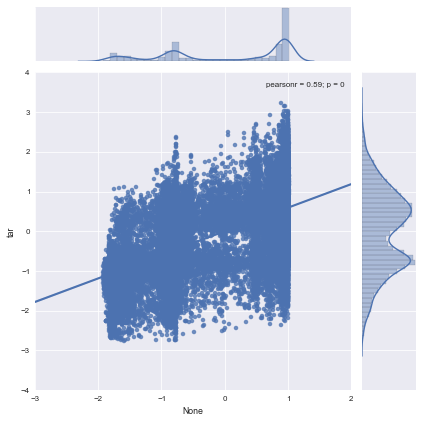

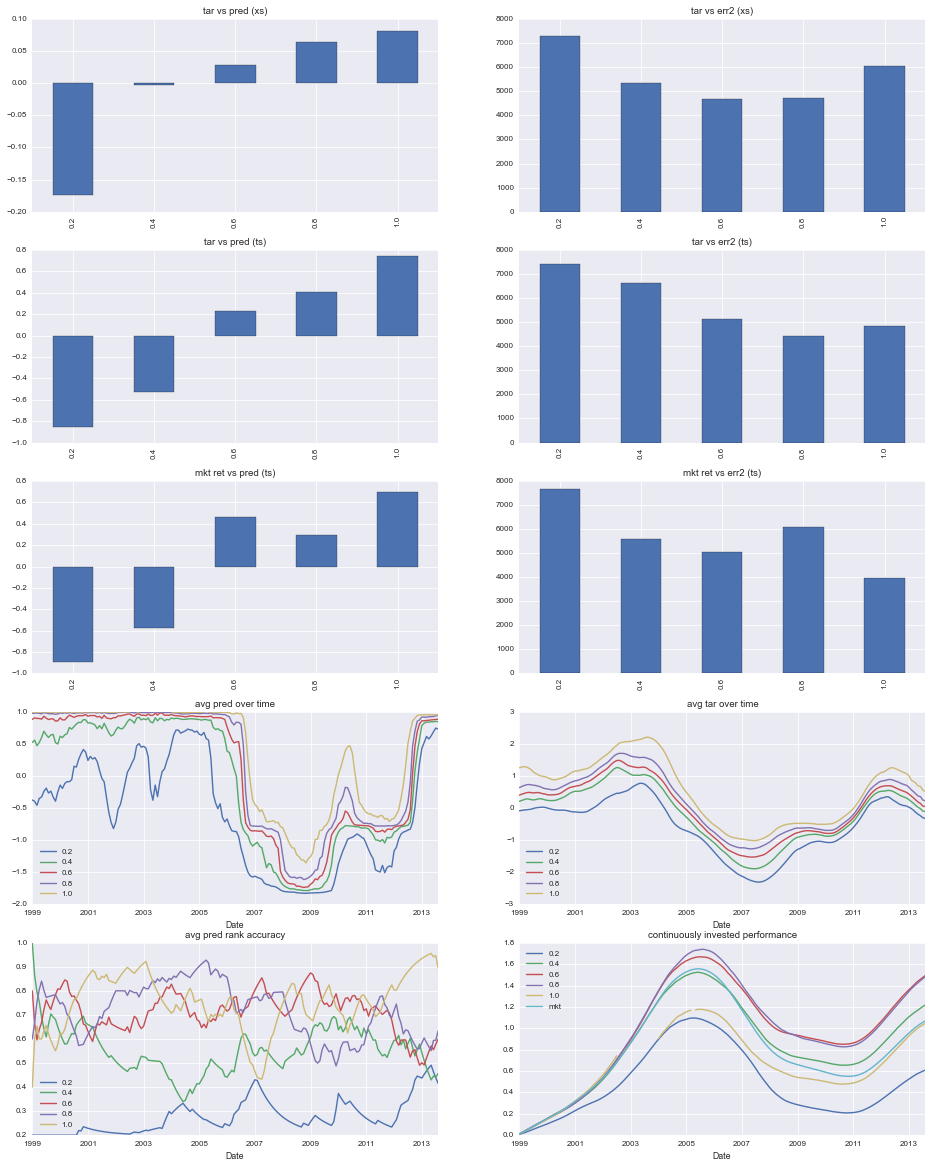

In [284]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))

sharpe ratios:
0.2    1.355548
0.4    1.884341
0.6    2.121116
0.8    1.585314
1.0    0.571367
mkt    1.837193
dtype: float64

r2: 0.34546138788


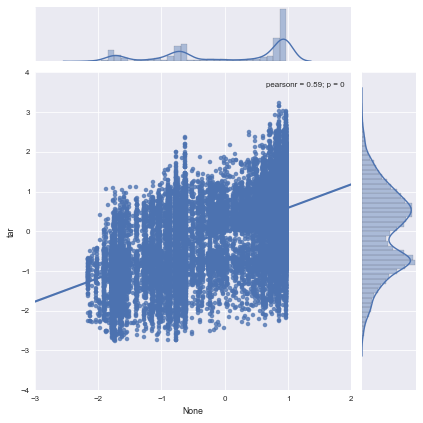

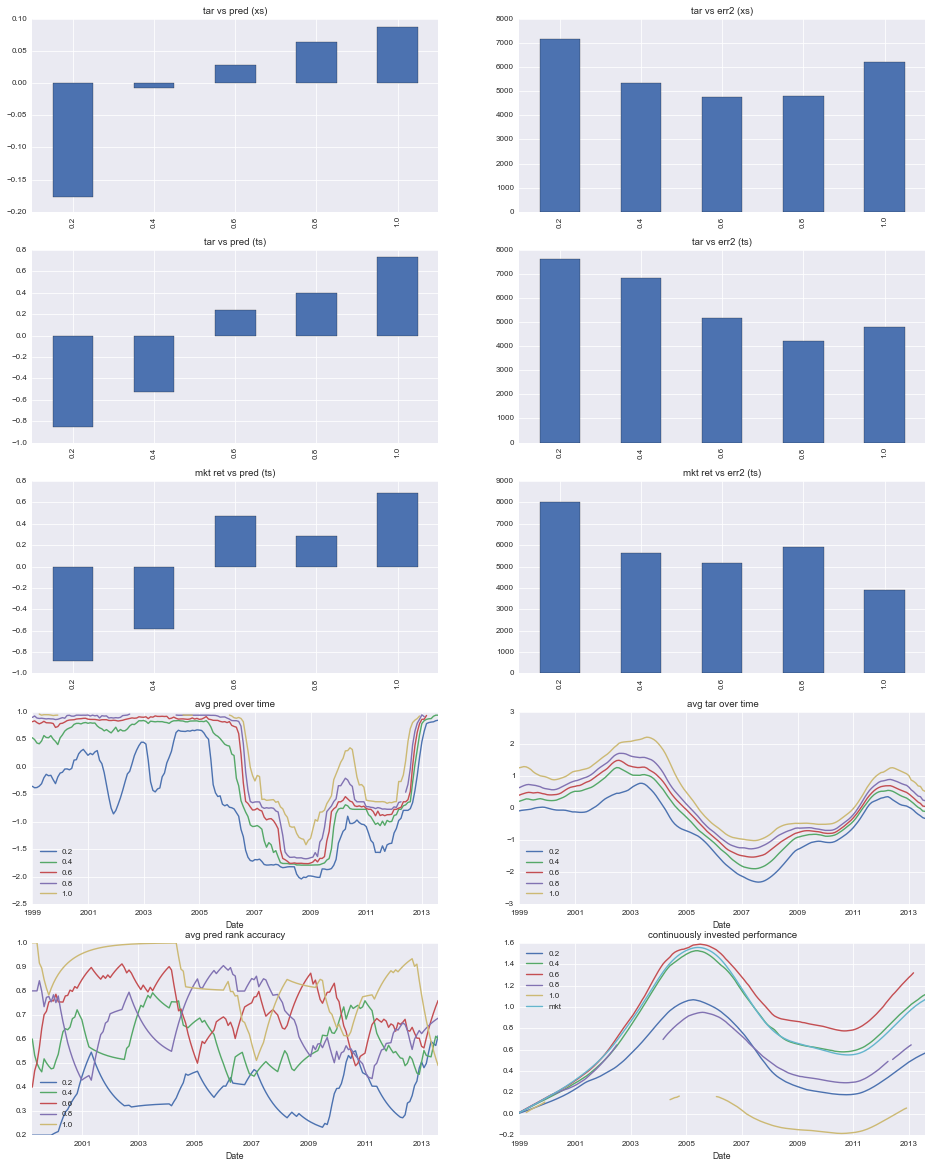

In [285]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 100, 200],
                                                            'max_depth': [1,3,5], 
                                                            'max_features': [None, 1, 2]}, 
                   cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))